# Train The Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
import pandas as pd

with open("/content/train.csv", 'r', encoding='utf-8') as file:
    txt = file.read()

# hyper para
blocksiz = 128
batchsiz = 64
epochs = 600
evalIntervals = 200
evaliters = 50
nemb = 42
nhead = 1
nlayers = 1
dropout = 0.0
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.001

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

specialTok = {
    "sep_token" : "<|sep|>"
}
# tokenizer already have eos and pad
tokenizer.add_special_tokens(specialTok)

vocabsiz = tokenizer.vocab_size
print(vocabsiz)

def enc(txt, tokenizer):
    tokens = tokenizer(
        txt,
        return_tensors="pt",
        truncation=True,
        padding=True,
        add_special_tokens=True
    )["input_ids"]

    return tokens.flatten()

data = enc(txt, tokenizer)
n = int(0.9*len(data))
trainData = data[:n]
valData = data[n:]

trainData = torch.tensor(trainData, dtype=torch.long)
valData = torch.tensor(valData, dtype=torch.long)
print(f"Train Data Shape: {trainData.shape}")
print(f"Validation Data Shape: {valData.shape}")

def getBatch(split):
    data = trainData if split == "train" else valData
    ix = torch.randint(0, len(data) - blocksiz, (batchsiz,))
    x = torch.stack([data[i:i+blocksiz] for i in ix])
    y = torch.stack([data[i+1:i+blocksiz+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

@torch.no_grad()
def estimateLoss():
    out = { }
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(evaliters)
        for k in range(evaliters):
            x, y = getBatch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()

    model.train()
    return out

class Head(nn.Module):
    def __init__(self, headsiz):
        super().__init__()
        self.key = nn.Linear(nemb, headsiz, bias=False)
        self.quary = nn.Linear(nemb, headsiz, bias=False)
        self.value = nn.Linear(nemb, headsiz, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(blocksiz, blocksiz)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.quary(x)

        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)

        v = self.value(x)
        out = w @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, nhead, headsiz):
        super().__init__()
        self.heads = nn.ModuleList([Head(headsiz) for _ in range(nhead)])
        self.proj = nn.Linear(headsiz * nhead, nemb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForwardNetwork(nn.Module):
    def __init__(self, nemb):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nemb, 4 * nemb),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * nemb, nemb),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, nemb, nhead):
        super().__init__()
        headsiz = nemb // nhead
        self.sa = MultiHeadAttention(nhead, headsiz)
        self.ffn = FeedForwardNetwork(nemb)
        self.ln_1 = nn.LayerNorm(nemb)
        self.ln_2 = nn.LayerNorm(nemb)

    def forward(self, x):
        x = x + self.sa(self.ln_1(x))
        x = x + self.ffn(self.ln_2(x))
        return x


class GPT(nn.Module):
    def __init__(self):
        super().__init__()
        newVocabSiz = len(tokenizer)
        self.wte = nn.Embedding(newVocabSiz, nemb)
        torch.nn.init.normal_(self.wte.weight, mean=0.0, std=0.02)

        self.wpe = nn.Embedding(blocksiz, nemb)
        self.block = nn.Sequential(*[Block(nemb, nhead=nhead) for _ in range(nlayers)])
        self.ln_f = nn.LayerNorm(nemb)

        self.lm_head = nn.Linear(nemb, vocabsiz)
        torch.nn.init.normal_(self.lm_head.weight, mean=0.0, std=0.02)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, ix, targt=None):
        B, T = ix.shape
        tokEmb = self.wte(ix)
        posEmb = self.wpe(torch.arange(T, device=device))

        x = tokEmb + posEmb
        x = self.block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targt is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targt = targt.view(B * T)
            loss = F.cross_entropy(logits, targt)
        return logits, loss

########### Truncate generally means to shorten something by cutting off a portion of it, ####

    def generate(self, ix, max_new_tokens, tokenizer, tempertaure=1.0, top_k=None):
        for _ in range(max_new_tokens):
            # Truncate input to the context window size
            ix_cond = ix[:, -min(blocksiz, ix.shape[1]):]
            logits, _ = self(ix_cond)
            logits = logits[:, -1, :]

            if tempertaure != 1.0:
                logits = logits / tempertaure

            if top_k is not None :
                val, indeces = torch.topk(logits, k=top_k, dim=-1)
                logits = torch.zeros_like(logits).scatter_(-1, indeces, val)

            probs = F.softmax(logits, dim=-1)

            ixNxt = torch.multinomial(probs, num_samples=1)
            ix = torch.cat((ix, ixNxt), dim=-1)

        return tokenizer.decode(ix[0].cpu().numpy().tolist(), skip_special_tokens=True)



# after add token all this line, [when init model]
newVocabSiz = len(tokenizer)
model = GPT()
model.wte = nn.Embedding(newVocabSiz, nemb)
torch.nn.init.normal_(model.wte.weight, mean=0.0, std=0.02)
m = model.to(device)


# Use compile
useCompile = False
if useCompile:
    model = torch.compile(model)
    print("Using compile")
else:
    print("not using Compile")

#--------------
# save checkpoint path
def saveCheckpoint(model, optim, epoch, loss, file):
    chekPnt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optim.state_dict(),
        "epoch": epoch,
        "loss": loss,

    }
    torch.save(chekPnt, file)
#--------------


# Add Mixed Precision
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
# lr schedular
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=5)

#ploting loss
traini=[ ]
trainloss_i=[]
valloss_i=[]

for i in range(epochs):
    if i % evaliters == 0 or i == epochs - 1:
        losses = estimateLoss()
        trainloss_i.append(losses["train"].item())
        valloss_i.append(losses["val"].item())
        traini.append(i)

        print(f"Epoch {i}/{epochs} | Train loss {losses['train']:.4f} | Val loss {losses['val']:.4f}")

    xb, yb = getBatch("train")
    with autocast():
        logits, loss = model(xb, yb)

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    optim.zero_grad(set_to_none=True)

    saveIntervals = 50 if i <= 200 else 400
    if i % saveIntervals == 0 or i == epochs - 1:
        saveCheckpoint(
            model,
            optim,
            i,
            valloss_i[-1] if valloss_i else float("inf"),
            "Therapy_bot_Trained_model.pth"
        )


49152


<ipython-input-3-51212c2095e2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainData = torch.tensor(trainData, dtype=torch.long)
<ipython-input-3-51212c2095e2>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valData = torch.tensor(valData, dtype=torch.long)
<ipython-input-3-51212c2095e2>:242: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train Data Shape: torch.Size([1843])
Validation Data Shape: torch.Size([205])
not using Compile
Epoch 0/600 | Train loss 10.8076 | Val loss 10.8123


<ipython-input-3-51212c2095e2>:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 50/600 | Train loss 6.7292 | Val loss 7.2454
Epoch 100/600 | Train loss 4.8329 | Val loss 5.5562
Epoch 150/600 | Train loss 3.4937 | Val loss 4.6928
Epoch 200/600 | Train loss 2.0081 | Val loss 3.9092
Epoch 250/600 | Train loss 1.0050 | Val loss 3.6296
Epoch 300/600 | Train loss 0.5146 | Val loss 3.5184
Epoch 350/600 | Train loss 0.2981 | Val loss 3.5114
Epoch 400/600 | Train loss 0.1948 | Val loss 3.5707
Epoch 450/600 | Train loss 0.1441 | Val loss 3.6016
Epoch 500/600 | Train loss 0.1159 | Val loss 3.6541
Epoch 550/600 | Train loss 0.0975 | Val loss 3.7462
Epoch 599/600 | Train loss 0.0856 | Val loss 3.8071


# Generate/Sample From the Model

In [4]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)  # Initial context
genTxt = model.generate(context, max_new_tokens=1000, tokenizer=tokenizer)
print(genTxt)

.
   How can I change my feeling of being worthless to everyone?"," passions intense.
   How can the motivation to remove ourselves from situations and relationships which'm This0-esteem.Otherwise, you're not worthless you need to understand why you need to this, if not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media.  Maybe instead of trying to change the ones which state that no person is worthless, and that everyone has most people, true.Also, since our culture's place. Without your way of thinking by glad to   Your feeling has tried or contemplated suicide. are not weno one essential for those that are feeling of being depressed and python never tried several things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've are feeling of being open to Clerk new once they require practice, but never tried or contemplated sui

# Polting The Lossses

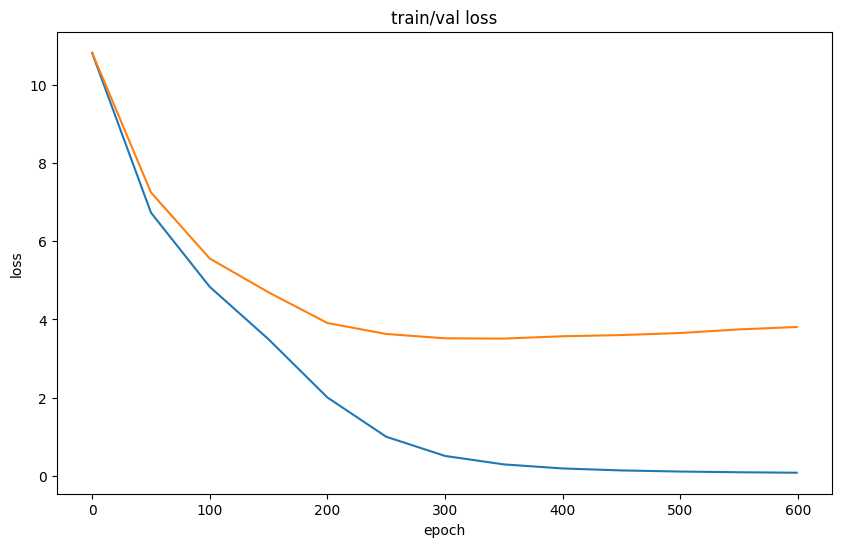

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(traini, trainloss_i, label="train loss")
plt.plot(traini, valloss_i, label="val loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("train/val loss")
plt.show()

# Fine Tune The model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchsiz = 64
blocksiz = 128
epochs = 100
lr = 1e-2

# Paths
preTrainedModel = "/content/Therapy_bot_Trained_model.pth"
datasetPath = "/content/finetune_train.csv"

# Add special tokens
specialTok = {"sep_token": "<|sep|>"}
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")
tokenizer.add_special_tokens(specialTok)

# Dataset Class
class TherapyData(Dataset):
    def __init__(self, filPth, tokenizer):
        with open(filPth, 'r', encoding='utf-8') as file:
            txt = file.readlines()

        self.examples = []
        for line in txt:
            tokLine = tokenizer.encode(line.strip(), truncation=True, max_length=blocksiz)
            self.examples.append(tokLine)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, ix):
        return torch.tensor(self.examples[ix], dtype=torch.long)

# Load Model and Tokenizer
def loadModelAndTokenize(checkPointPath):
    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")
    model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

    # Resize embeddings to include special tokens
    model.resize_token_embeddings(len(tokenizer))

    # Load checkpoint
    checkpoint = torch.load(checkPointPath, map_location=device)
    state_dict = torch.load(preTrainedModel)
    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)

    return model, tokenizer

# Fine-Tuning Function
def fineTuneModel(model, tokenizer, datasetFile):
    # Prepare dataset and dataloader
    dataset = TherapyData(datasetFile, tokenizer)
    dataloader = DataLoader(
        dataset,
        batch_size=batchsiz,
        shuffle=True,
        collate_fn=lambda x: torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=tokenizer.pad_token_id),
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, inputs in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} | Loss: {loss.item()}")

        print(f"Epoch {epoch + 1} completed. Average Loss: {total_loss / len(dataloader)}")

    # Save the fine-tuned model and tokenizer
    torch.save(model.state_dict(), "fine_tuned_model.pth")
    torch.save(tokenizer, "fine_tuned_tokenizer.pth")
    print("Model and tokenizer saved successfully.")

# Load model and fine-tune
model, tokenizer = loadModelAndTokenize(preTrainedModel)
fineTuneModel(model, tokenizer, datasetPath)

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

<ipython-input-6-469d500bedb3>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkPointPath, map_location=device)
<ipython-input-6-469d500bedb3>:

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 63.06 MiB is free. Process 19902 has 14.68 GiB memory in use. Of the allocated memory 14.44 GiB is allocated by PyTorch, and 108.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)